In [1]:
%load_ext autoreload
%autoreload 2
%load_ext sql

In [2]:
import sys, os
import numpy as np
import pandas as pd
import datapackage
import importlib
import sqlalchemy as sa
import pathlib
import yaml
import pudl

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
%matplotlib inline

In [5]:
#plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,4)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_settings

{'pudl_in': '/home/zane/code/catalyst/pudl-work',
 'data_dir': '/home/zane/code/catalyst/pudl-work/data',
 'settings_dir': '/home/zane/code/catalyst/pudl-work/settings',
 'pudl_out': '/home/zane/code/catalyst/pudl-work',
 'sqlite_dir': '/home/zane/code/catalyst/pudl-work/sqlite',
 'parquet_dir': '/home/zane/code/catalyst/pudl-work/parquet',
 'datapkg_dir': '/home/zane/code/catalyst/pudl-work/datapkg',
 'notebook_dir': '/home/zane/code/catalyst/pudl-work/notebook',
 'ferc1_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/pudl.sqlite'}

# Target Data
* **p115 L2(g)** Operating Revenues (Electric Utility) Current Year
* **p115 L2(h)** Operating Expenses (Electric Utility) Prior Year
* **p115 L26(g)** Net Util Oper Inc Current Year (Electric Utility)
* **p115 L26(h)** Net Util Oper Inc Prior Year (Electric Utility)
* **P206 L104(b)** TOTAL Electric Plant in Service Bal Beginning of Year
* **P206 L104(g)** TOTAL Electric Plant in Service Bal End of Year
* **P336 L12(f)** Electric Depreciation Expense

## Tables to pull:
* p115 => `f1_incm_stmnt_2` and `f1_income_stmnt`
* p206 => `f1_plant_in_srvce`
* p336 => `f1_edcfu_epda` and `f1_dacs_epda` and `f1_acb_epda`

In [7]:
target_tables = [
    "f1_income_stmnt", "f1_incm_stmnt_2",
    "f1_plant_in_srvce",
    "f1_edcfu_epda", "f1_dacs_epda", "f1_acb_epda"
]

## Associate FERC 1 Utilities with Target EIA IDs

In [8]:
utilities_eia = pd.read_sql("utilities_eia", pudl_engine)
utilities_ferc1 = pd.read_sql("utilities_ferc1", pudl_engine)
utilities_glue = (
    pd.merge(utilities_eia, utilities_ferc1, on="utility_id_pudl", how="outer")
    .astype({
        "utility_id_eia": "Int64",
        "utility_id_ferc1": "Int64"
    })
)

rbinz_utils = pd.read_csv("rbinz_instructions.csv", index_col="utility_id_eia")
output_utils = (
    rbinz_utils
    .merge(utilities_eia, how="left", on="utility_id_eia", suffixes=("_rbinz", "_pudl"))
    .astype({"utility_id_pudl": 'Int64'})
    .dropna(subset=["utility_id_pudl"])
    .merge(utilities_ferc1, how="left", on="utility_id_pudl")
    .astype({"utility_id_ferc1": 'Int64'})
    .set_index("utility_id_eia")
    .dropna(subset=["utility_id_ferc1"])
)
output_utils

,utility_name_eia_rbinz,questionable,utility_name_eia_pudl,utility_id_pudl,utility_id_ferc1,utility_name_ferc1
utility_id_eia,,,,,,
195,Alabama Power Company,False,Alabama Power Co,18,2,ALABAMA POWER COMPANY
213,Alaska Electric Light and Power Co.,False,Alaska Electric Light&Power Co,19,3,Alaska Electric Light and Power Company
19436,Union Electric Company,False,Union Electric Co - (MO),334,177,UNION ELECTRIC COMPANY
733,Appalachian Power Company,False,Appalachian Power Co,29,6,Appalachian Power Company
803,Arizona Public Service Company,False,Arizona Public Service Co,31,7,Arizona Public Service Company
20169,Avista Corporation,False,Avista Corp,35,187,Avista Corporation
19545,"Black Hills Power, Inc.",False,"Black Hills Power, Inc. d/b/a",42,12,"Black Hills Power, Inc."
3046,Carolina Power & Light Company,False,Duke Energy Progress - (NC),97,17,"Duke Energy Progress, Inc."
3265,Cleco Power LLC,False,Cleco Power LLC,69,22,Cleco Power LLC


In [9]:
bad_utils = rbinz_utils.loc[rbinz_utils.index.difference(output_utils.index)]
bad_utils

,utility_name_eia,questionable
utility_id_eia,,
13780,Northern States Power Company - WI,False
13809,Northwestern Public Service Co (SD),True
19446,Union Light Heat & Power Co (KY),True
22500,Westar Energy (KPL),False


In [10]:
output_utils = output_utils.reset_index()
bad_utils = bad_utils.reset_index()

# Unfinished extractions

In [11]:
f1_income_statement_2 = pd.read_sql("f1_incm_stmnt_2", ferc1_engine) # Page 2 of the Income Statements -- not immediately required for rbinz
f1_plant_in_service = pd.read_sql("f1_plant_in_srvce", ferc1_engine)
f1_edcfu_epda = pd.read_sql("f1_edcfu_epda", ferc1_engine)
f1_acb_epda = pd.read_sql("f1_acb_epda", ferc1_engine)

# Generating new row maps

In [12]:
def get_row_literals(table_name, report_year, ferc1_engine):
    row_literals = (
        pd.read_sql("f1_row_lit_tbl", ferc1_engine)
        .query(f"sched_table_name=='{table_name}'")
        .query(f"report_year=={report_year}")
        .sort_values("row_number")
    )
    return row_literals

In [13]:
target_tables

['f1_income_stmnt',
 'f1_incm_stmnt_2',
 'f1_plant_in_srvce',
 'f1_edcfu_epda',
 'f1_dacs_epda',
 'f1_acb_epda']

In [14]:
get_row_literals("f1_dacs_epda", 2005, ferc1_engine)

,sched_table_name,report_year,row_number,row_seq,row_literal,row_status,row_chg_yr
28269,f1_dacs_epda,2005,1,1,Intangible Plant,A,1994
28340,f1_dacs_epda,2005,2,2,Steam Production Plant,A,1994
28408,f1_dacs_epda,2005,3,3,Nuclear Production Plant,A,1994
28474,f1_dacs_epda,2005,4,4,Hydraulic Production Plant-Conventional,A,1994
28540,f1_dacs_epda,2005,5,5,Hydraulic Production Plant-Pumped Storage,A,1994
28605,f1_dacs_epda,2005,6,6,Other Production Plant,A,1994
28668,f1_dacs_epda,2005,7,7,Transmission Plant,A,1994
28731,f1_dacs_epda,2005,8,8,Distribution Plant,A,1994
28793,f1_dacs_epda,2005,9,9,General Plant,A,1994
28854,f1_dacs_epda,2005,10,10,Common Plant-Electric,A,1994


# Utility Revenues and Income (`f1_income_stmnt`)

In [15]:
f1_income_statement = pd.read_sql("f1_income_stmnt", ferc1_engine)
ferc1_row_maps_pkg = "pudl.package_data.meta.ferc1_row_maps"
row_map = pd.read_csv(
    importlib.resources.open_text(ferc1_row_maps_pkg, "f1_income_stmnt_map.csv"),
    index_col=0, comment="#"
)
data_cols = [
    'current_yr_total', 'previous_yr_tot',
    'cy_elctrc_total',  'prev_yr_elc_tot',
    'cy_gas_total',     'prev_yr_gas_tot',
    'curr_3_mon',       'prior_3_mon',
    'cy_other_total_1', 'prev_yr_other_1',
    'cy_other_total_2', 'prev_yr_other_2',
    'cy_other_total_3', 'prev_yr_other_3',
    'cy_other_total_4', 'prev_yr_other_4',
]
normed_income = (
    pudl.transform.ferc1.unpack_rows(f1_income_statement, row_map, data_cols)
)

0.0753% of unpacked records were duplicates, and discarded.


In [83]:
cur_yr_cats = {
    "current_yr_total": "ytd_total",  # YTD Total    
    "cy_elctrc_total": "electric",  # YTD Total
    "cy_gas_total": "gas",  # YTD Total
    "cy_other_total_1": "other_util_1",  # YTD Total
    "cy_other_total_2": "other_util_2",  # YTD Total
    "cy_other_total_3": "other_util_3",  # YTD Total
    "cy_other_total_4": "other_util_4",  # YTD Total
}
prev_yr_cats = {
    "previous_yr_tot": "ytd_total",  # YTD Total
    "prev_yr_elc_tot": "electric",  # YTD Total
    "prev_yr_gas_tot": "gas",  # YTD Total
    "prev_yr_other_1": "other_util_1",  # YTD Total
    "prev_yr_other_2": "other_util_2",  # YTD Total
    "prev_yr_other_3": "other_util_3",  # YTD Total
    "prev_yr_other_4": "other_util_4",  # YTD Total
}
cur_qtr_cats = {
    "curr_3_mon": "qtr_total",  # Quarterly total
}
prev_qtr_cats = {
    "prior_3_mon": "qtr_total",  # Quarterly total
}

current_year = pudl.transform.ferc1.cols_to_cats(normed_income, "report_type", cur_yr_cats)
previous_year = pudl.transform.ferc1.cols_to_cats(normed_income, "report_type", prev_yr_cats)
current_qtr = pudl.transform.ferc1.cols_to_cats(normed_income, "report_type", cur_qtr_cats)
previous_qtr = pudl.transform.ferc1.cols_to_cats(normed_income, "report_type", prev_qtr_cats)

Col: current_yr_total, Cat: ytd_total
Col: cy_elctrc_total, Cat: electric
Col: cy_gas_total, Cat: gas
Col: cy_other_total_1, Cat: other_util_1
Col: cy_other_total_2, Cat: other_util_2
Col: cy_other_total_3, Cat: other_util_3
Col: cy_other_total_4, Cat: other_util_4
Col: previous_yr_tot, Cat: ytd_total
Col: prev_yr_elc_tot, Cat: electric
Col: prev_yr_gas_tot, Cat: gas
Col: prev_yr_other_1, Cat: other_util_1
Col: prev_yr_other_2, Cat: other_util_2
Col: prev_yr_other_3, Cat: other_util_3
Col: prev_yr_other_4, Cat: other_util_4
Col: curr_3_mon, Cat: qtr_total
Col: prior_3_mon, Cat: qtr_total


In [84]:
current_year.sample(5)

var_name,respondent_id,report_year,report_prd,spplmnt_num,accretion_expns,amort_conversion_expns,amort_depl_utility_plant,amort_loss,amort_util_plant_acq_adj,deferred_income_tax,deferred_income_tax_credit,depr_expns_asset_retirement,depreciation_expenses,gain_disp_allow,gain_disp_util_plant,income_tax_fed,investment_tax_credit,loss_disp_allow,loss_disp_util_plant,maintenance_expenses,net_util_op_inc,non_income_tax,op_revenues,operation_expenses,other,regulatory_credits,regulatory_debits,total_utility_opex,report_type
7893,148,2013,3,0,418903.0,NaN,1818602.0,NaN,NaN,59596277.0,39426679.0,152375.0,21204683.0,176.0,NaN,-9266432.0,-214104.0,NaN,NaN,28572406.0,26448085.0,9996301.0,2.622079e+08,163854934.0,-1952065.0,NaN,1004802.0,2.357598e+08,ytd_total
31376,167,2011,12,0,NaN,NaN,NaN,NaN,NaN,1224252.0,NaN,NaN,860907.0,NaN,NaN,-738704.0,-2210.0,NaN,NaN,581775.0,900656.0,364279.0,1.747592e+07,14413799.0,-128833.0,NaN,NaN,1.657526e+07,gas
23654,171,2009,6,0,NaN,NaN,185906.0,NaN,NaN,86797.0,NaN,NaN,16113209.0,5823.0,NaN,-3350670.0,NaN,NaN,NaN,11201485.0,3401157.0,2737597.0,1.101868e+08,79722132.0,95020.0,NaN,NaN,1.067857e+08,electric
22155,146,1999,12,0,NaN,NaN,209368.0,17504856.0,17410421.0,50508998.0,45337182.0,NaN,47484971.0,32348.0,NaN,32434878.0,-5454510.0,NaN,NaN,52481218.0,124604764.0,43282254.0,1.160572e+09,820816398.0,4658038.0,NaN,NaN,1.035967e+09,electric
10963,206,2005,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2474498.0,NaN,NaN,NaN,NaN,NaN,NaN,1875848.0,2597874.0,542976.0,3.287050e+07,25322248.0,NaN,NaN,57061.0,3.027263e+07,ytd_total


In [143]:
current_year_out = (
    current_year.query("report_prd==12")
    .query("report_type=='electric'")
    .loc[:, ["respondent_id", "report_year", "op_revenues", "total_utility_opex",  "net_util_op_inc"]]
    .rename(columns={
        "op_revenues": "operating_revenues",
        "total_utility_opex": "operating_expenses",
        "net_util_op_inc": "net_operating_income",
        "respondent_id": "utility_id_ferc1",
    })
)
previous_year_out = (
    previous_year.query("report_prd==12")
    .query("report_type=='electric'")
    .loc[:, ["respondent_id", "report_year", "op_revenues", "total_utility_opex",  "net_util_op_inc"]]
    .rename(columns={
        "op_revenues": "operating_revenues",
        "total_utility_opex": "operating_expenses",
        "net_util_op_inc": "net_operating_income",
        "respondent_id": "utility_id_ferc1",
    })
)

income_out = (
    pd.merge(current_year_out, previous_year_out, on=["utility_id_ferc1", "report_year"], suffixes=("_curr_yr", "_prev_yr"))
    .merge(utilities_glue.dropna(subset=["utility_id_ferc1"]), on="utility_id_ferc1", how="inner")
    .loc[:,[
        'utility_id_ferc1',
        'utility_name_ferc1',
        'report_year',
        'utility_id_eia',
        'utility_name_eia',
        'utility_id_pudl',
        'operating_revenues_curr_yr',
        'operating_expenses_curr_yr',
        'net_operating_income_curr_yr',
        'operating_revenues_prev_yr',
        'operating_expenses_prev_yr',
        'net_operating_income_prev_yr',
    ]]
)
income_out

,utility_id_ferc1,utility_name_ferc1,report_year,utility_id_eia,utility_name_eia,utility_id_pudl,operating_revenues_curr_yr,operating_expenses_curr_yr,net_operating_income_curr_yr,operating_revenues_prev_yr,operating_expenses_prev_yr,net_operating_income_prev_yr
0,1,AEP Generating Company,1994,343,AEP Generating Company,7,236041442.0,219659755.0,16381687.0,229272978.0,212097046.0,17175932.0
1,1,AEP Generating Company,1995,343,AEP Generating Company,7,231794921.0,218752275.0,13042646.0,236041442.0,219624420.0,16417022.0
2,1,AEP Generating Company,1996,343,AEP Generating Company,7,225891551.0,215996685.0,9894866.0,231794921.0,218752275.0,13042646.0
3,1,AEP Generating Company,1997,343,AEP Generating Company,7,227868320.0,218827948.0,9040372.0,225891551.0,215996685.0,9894866.0
4,1,AEP Generating Company,1998,343,AEP Generating Company,7,224146041.0,215414873.0,8731168.0,227868320.0,218827948.0,9040372.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5196,455,ITC Interconnection LLC,2017,NaN,NaN,4840,3129915.0,1882800.0,1247115.0,1541581.0,782871.0,758710.0
5197,455,ITC Interconnection LLC,2018,NaN,NaN,4840,2671916.0,1492840.0,1179076.0,3129915.0,1882800.0,1247115.0
5198,512,"Transource West Virginia, LLC",2016,NaN,NaN,4839,489603.0,465269.0,24334.0,NaN,14941.0,-14941.0
5199,512,"Transource West Virginia, LLC",2017,NaN,NaN,4839,702391.0,414539.0,287852.0,489603.0,465269.0,24334.0


## Test out the data with some plots...

In [144]:
electric_income = (
    current_year
    .query("report_type=='electric'")
    .query("report_prd==12")
    .loc[:,["utility_id_eia", "report_year", "net_util_op_inc"]]
    .query("net_util_op_inc>=-1e8 and net_util_op_inc<=2e9")
)
gas_income = (
    current_year
    .query("report_type=='gas'")
    .query("report_prd==12")
    .loc[:,["utility_id_eia", "report_year", "net_util_op_inc"]]
    .query("net_util_op_inc>=-1e8 and net_util_op_inc<=2e9")
)

/home/zane/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


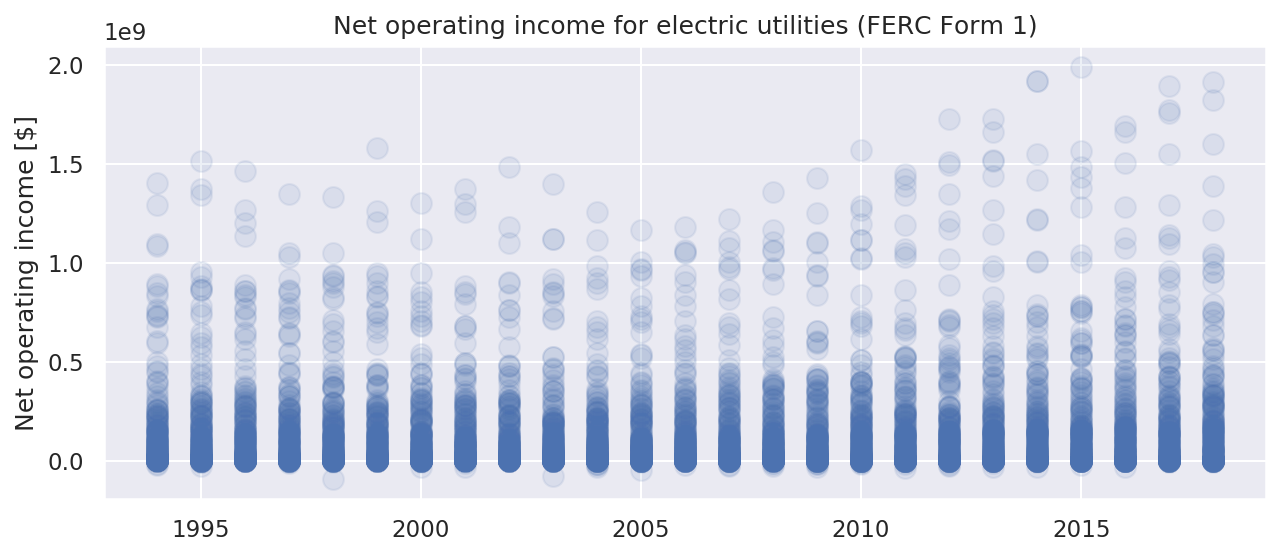

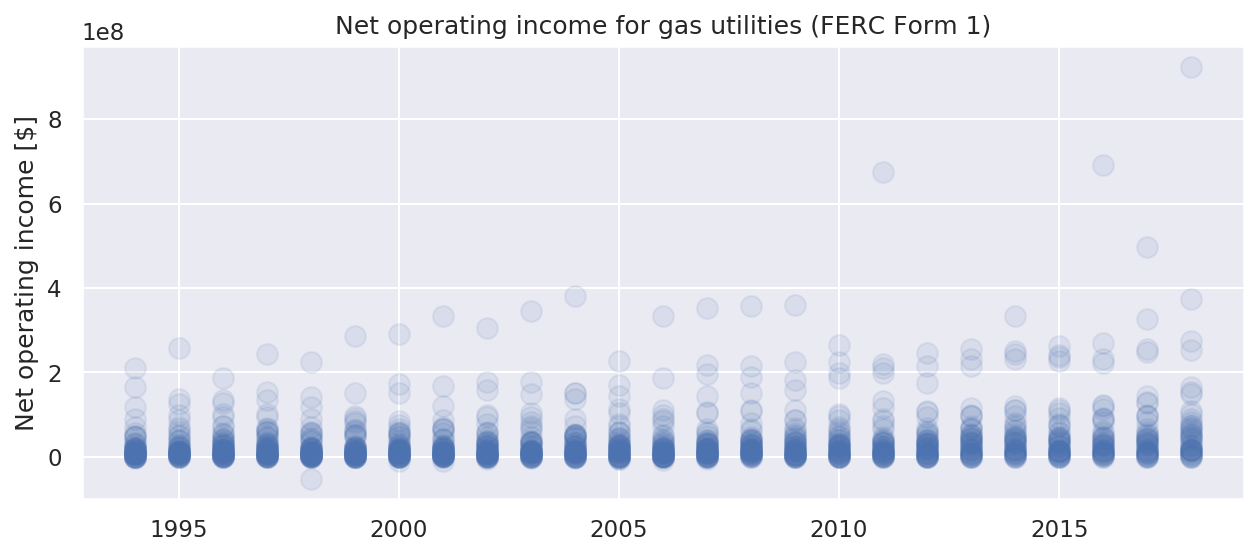

In [145]:
plt.scatter(x=electric_income.report_year, y=electric_income.net_util_op_inc, alpha=0.1, s=100)
plt.title("Net operating income for electric utilities (FERC Form 1)")
plt.ylabel("Net operating income [$]")
plt.show()

plt.scatter(x=gas_income.report_year, y=gas_income.net_util_op_inc, alpha=0.1, s=100)
plt.title("Net operating income for gas utilities (FERC Form 1)")
plt.ylabel("Net operating income [$]")
plt.show()

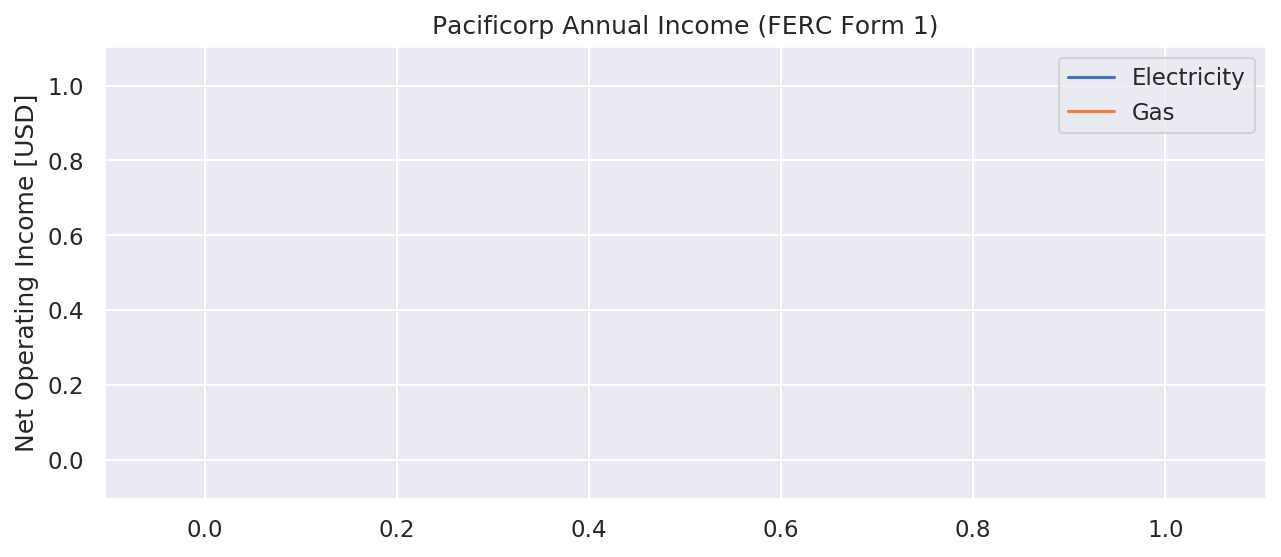

In [146]:
pacificorp_elec = electric_income.query("utility_id_eia==14354")
pacificorp_gas = gas_income.query("utility_id_eia==14354")
plt.plot(pacificorp_elec.report_year, pacificorp_elec.net_util_op_inc, label="Electricity")
plt.plot(pacificorp_gas.report_year, pacificorp_gas.net_util_op_inc, label="Gas")
plt.title("Pacificorp Annual Income (FERC Form 1)")
plt.ylabel("Net Operating Income [USD]")
plt.legend()
plt.savefig("PacificorpIncome.jpg")

In [147]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine)

In [148]:
gf_eia923 = pudl_out.gf_eia923()

In [149]:
pacificorp_net_income_per_mwh = (
    gf_eia923.query("utility_id_eia==14354")
    .groupby(["report_date", "utility_id_eia"])
    .agg({"net_generation_mwh": sum})
    .reset_index()
    .assign(report_year=lambda x: pd.to_datetime(x.report_date).dt.year) # Gawd this is dumb
    .drop("utility_id_eia", axis="columns")
    .merge(pacificorp_elec, on="report_year", how="left")
    .assign(net_income_per_mwh=lambda x: x["net_util_op_inc"]/(12.0*x["net_generation_mwh"]))
)

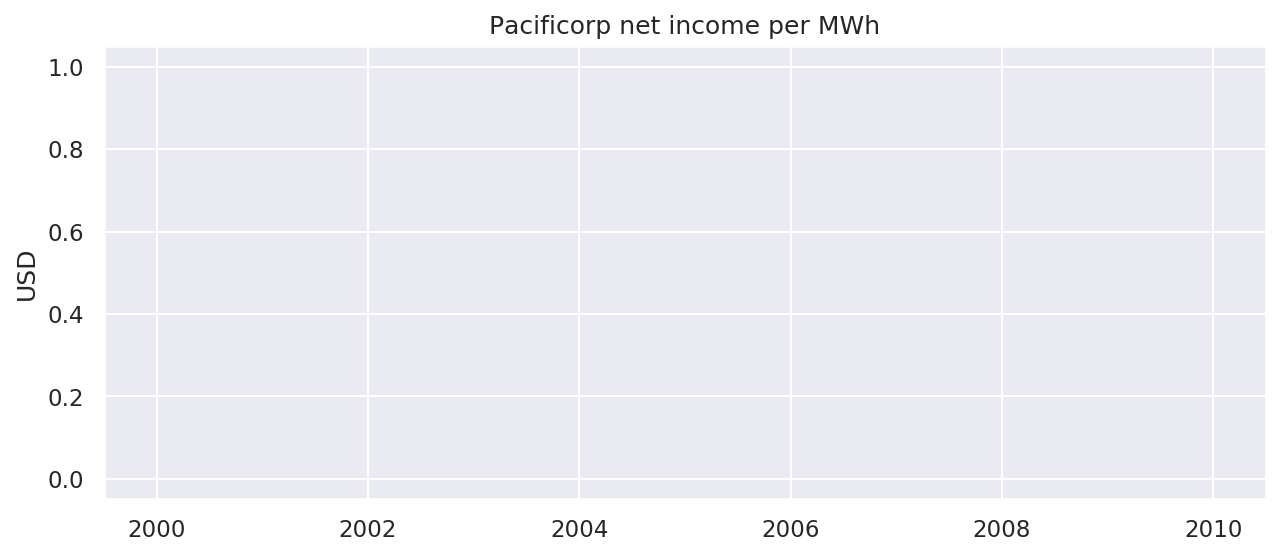

In [150]:
plt.scatter(x=pacificorp_net_income_per_mwh.report_date, y=pacificorp_net_income_per_mwh.net_income_per_mwh)
plt.ylabel("USD")
plt.title("Pacificorp net income per MWh");

# Electric Depreciation (`f1_dacs_epda`)

In [151]:
f1_dacs_epda = pd.read_sql("f1_dacs_epda", ferc1_engine)
depr_row_map = pd.read_csv(
    importlib.resources.open_text(ferc1_row_maps_pkg, "f1_dacs_epda_map.csv"),
    index_col=0, comment="#"
)
depr_data_cols = [
    'depr_expn',
    'depr_asset_retire',
    'limterm_elc_plnt',
    'othr_elc_plnt',
    'total',
]
normed_depr = (
    pudl.transform.ferc1.unpack_rows(f1_dacs_epda, depr_row_map, depr_data_cols)["total"]
    .reset_index()
    .rename(columns={"respondent_id": "utility_id_ferc1"})
    .merge(utilities_glue.dropna(subset=["utility_id_ferc1"]), on="utility_id_ferc1", how="inner")
)
depr_out = normed_depr.loc[:,["utility_id_ferc1", "utility_name_ferc1", "report_year", "utility_id_eia", "utility_name_eia", "utility_id_pudl", "total_electric_plant"]]
depr_out

0.0000% of unpacked records were duplicates, and discarded.


,utility_id_ferc1,utility_name_ferc1,report_year,utility_id_eia,utility_name_eia,utility_id_pudl,total_electric_plant
0,1,AEP Generating Company,1994,343,AEP Generating Company,7,21614698.0
1,1,AEP Generating Company,1995,343,AEP Generating Company,7,21673871.0
2,1,AEP Generating Company,1996,343,AEP Generating Company,7,21648443.0
3,1,AEP Generating Company,1997,343,AEP Generating Company,7,21613546.0
4,1,AEP Generating Company,1998,343,AEP Generating Company,7,21651686.0
...,...,...,...,...,...,...,...
4995,455,ITC Interconnection LLC,2016,NaN,NaN,4840,222100.0
4996,455,ITC Interconnection LLC,2017,NaN,NaN,4840,410292.0
4997,455,ITC Interconnection LLC,2018,NaN,NaN,4840,410460.0
4998,512,"Transource West Virginia, LLC",2018,NaN,NaN,4839,4013.0


## Test out the data with some plots...

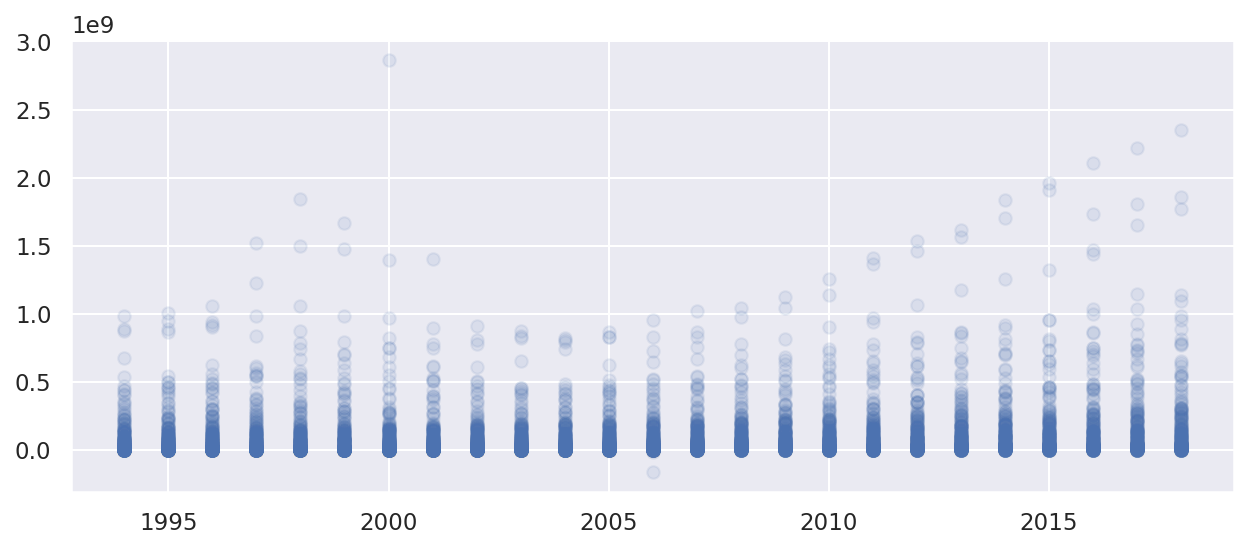

In [152]:
plt.scatter(x=normed_depr.report_year, y=normed_depr.total_electric_plant, alpha=0.1)

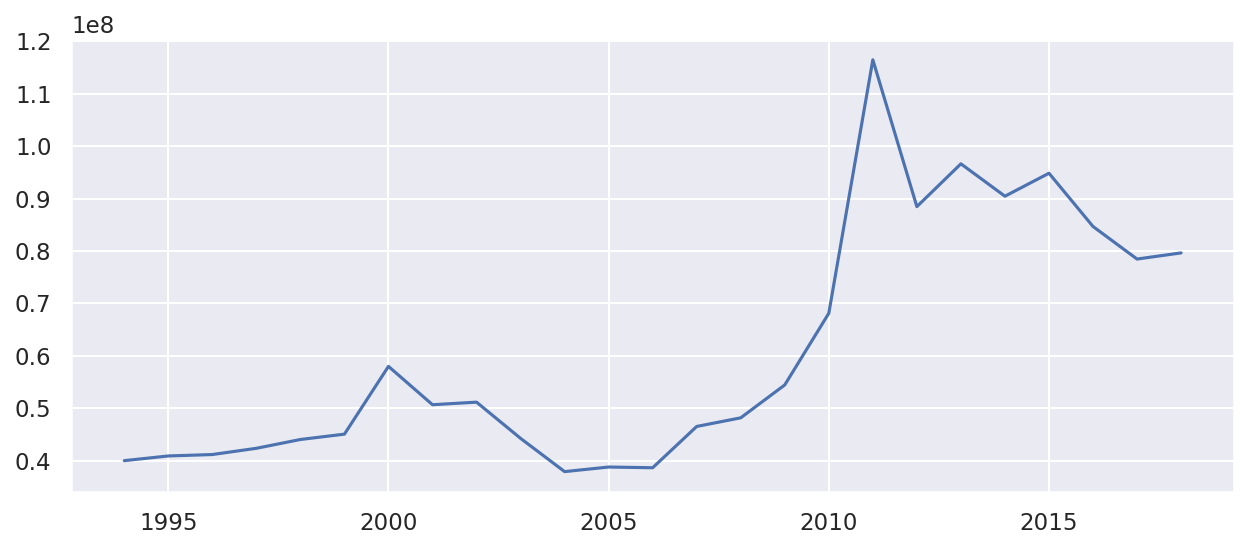

In [153]:
psco_depr = normed_depr.query("utility_id_ferc1==145")
psco_depr.columns
plt.plot(psco_depr.report_year, psco_depr.steam_production_plant)

# Plant in Service (`f1_plant_in_srvce`)

In [154]:
f1_plant_in_srvce = pd.read_sql("f1_plant_in_srvce", ferc1_engine)
pis_row_map = pd.read_csv(
    importlib.resources.open_text(ferc1_row_maps_pkg, "f1_plant_in_srvce_map.csv"),
    index_col=0, comment="#"
)
pis_data_cols = [
    "begin_yr_bal",
    "addition",
    "retirements",
    "adjustments",
    "transfers",
    "yr_end_bal",
]
normed_pis = (
    pudl.transform.ferc1.unpack_rows(f1_plant_in_srvce, pis_row_map, pis_data_cols)
)

pis_tables = {col: normed_pis[col] for col in pis_data_cols}
pis_out = (
    pd.merge(pis_tables["begin_yr_bal"]["total"], pis_tables["yr_end_bal"]["total"], left_index=True, right_index=True, suffixes=("_start", "_end"))
    .reset_index()
    .drop(["report_prd", "spplmnt_num"], axis="columns")
    .rename(columns={
        "respondent_id": "utility_id_ferc1",
        "total_start": "year_start_balance",
        "total_end": "year_end_balance"
    })
    .merge(utilities_glue.dropna(subset=["utility_id_ferc1"]), on="utility_id_ferc1", how="inner")
    .loc[:,["utility_id_ferc1", "utility_name_ferc1", "report_year", "utility_id_eia", "utility_name_eia", "utility_id_pudl", "year_start_balance", "year_end_balance"]]
)
pis_out

0.0247% of unpacked records were duplicates, and discarded.


,utility_id_ferc1,utility_name_ferc1,report_year,utility_id_eia,utility_name_eia,utility_id_pudl,year_start_balance,year_end_balance
0,1,AEP Generating Company,1994,343,AEP Generating Company,7,624527969.0,625810653.0
1,1,AEP Generating Company,1995,343,AEP Generating Company,7,625810653.0,625611218.0
2,1,AEP Generating Company,1996,343,AEP Generating Company,7,625611218.0,626141431.0
3,1,AEP Generating Company,1997,343,AEP Generating Company,7,626141431.0,626029597.0
4,1,AEP Generating Company,1998,343,AEP Generating Company,7,626029597.0,627375219.0
...,...,...,...,...,...,...,...,...
5074,455,ITC Interconnection LLC,2016,NaN,NaN,4840,19519812.0,19548673.0
5075,455,ITC Interconnection LLC,2017,NaN,NaN,4840,19548673.0,19558061.0
5076,455,ITC Interconnection LLC,2018,NaN,NaN,4840,19558061.0,19558061.0
5077,512,"Transource West Virginia, LLC",2018,NaN,NaN,4839,NaN,97150.0


# Bringing the data together for output
* Use Binz' target list to select a subset of the tables/columns.
* Add missing & unmapped `utility_id_ferc1` values to the (FERC) target list:
    - **`eia 22500`** : `ferc1 191, 276` (Westar Energy)
    - **`eia 13780`** : `ferc1 121` (Northern States Power Company - WI)
    - **`eia 13809, 13902`** : `ferc1 122` (Northwestern Public Service Co)
* Join the requested columns together based on report_year and respondent_id
* Output as a CSV for Binz

In [155]:
depr_out.sample(5)

,utility_id_ferc1,utility_name_ferc1,report_year,utility_id_eia,utility_name_eia,utility_id_pudl,total_electric_plant
1763,89,Madison Gas and Electric Company,2018,11479,Madison Gas & Electric Co,171,46312936.0
4701,295,"DATC Path 15, LLC",2015,NaN,NaN,83,5046878.0
3314,164,Southwestern Electric Power Company,1999,17698,Southwestern Electric Power Co,301,100968341.0
3168,157,Sierra Pacific Power Company d/b/a NV Energy,2017,17166,Sierra Pacific Power Co,287,104236256.0
3186,159,South Carolina Electric & Gas Company,1996,17539,South Carolina Electric&Gas Company,292,116137469.0


In [156]:
pis_out.sample(5)

,utility_id_ferc1,utility_name_ferc1,report_year,utility_id_eia,utility_name_eia,utility_id_pudl,year_start_balance,year_end_balance
1697,87,"Entergy Louisiana, LLC",2003,NaN,NaN,108,5.557662e+09,5.836800e+09
2837,143,Potomac Electric Power Company,1995,NaN,NaN,264,5.612917e+09,5.854860e+09
1210,61,Green Mountain Power Corp,2006,7601,Green Mountain Power Corp,128,3.479468e+08,3.629697e+08
387,19,CENTRAL HUDSON GAS & ELECTRIC CORPORATION,2008,3249,Central Hudson Gas & Elec Corp,55,8.073659e+08,8.624188e+08
550,28,CITIZENS' ELECTRIC COMPANY,1994,NaN,NaN,67,8.040441e+06,8.390768e+06


In [157]:
income_out.sample(5)

,utility_id_ferc1,utility_name_ferc1,report_year,utility_id_eia,utility_name_eia,utility_id_pudl,operating_revenues_curr_yr,operating_expenses_curr_yr,net_operating_income_curr_yr,operating_revenues_prev_yr,operating_expenses_prev_yr,net_operating_income_prev_yr
2295,117,Niagara Mohawk Power Corporation,2002,NaN,NaN,216,3.286720e+09,2.859553e+09,427167094.0,3.393142e+09,2.960948e+09,432194258.0
934,46,Duquesne Light Company,2003,NaN,NaN,98,8.061100e+08,6.867690e+08,119341016.0,9.445890e+08,8.181173e+08,126471722.0
4208,210,MidAmerican Energy Company,2002,12341,MidAmerican Energy Co,185,1.353216e+09,1.157969e+09,195247395.0,1.314683e+09,1.118565e+09,196118123.0
965,48,Edison Sault Electric Company,2004,NaN,NaN,102,4.359644e+07,4.004143e+07,3555011.0,4.238344e+07,3.858731e+07,3796128.0
253,11,Emera Maine,2017,1179,Emera Maine,105,1.803993e+08,1.327498e+08,47649524.0,1.718336e+08,1.196343e+08,52199287.0


In [158]:
all_out = (
    pd.merge(
        income_out,
        pis_out.loc[:,["utility_id_ferc1", "report_year", "year_start_balance", "year_end_balance"]],
        on=["utility_id_ferc1", "report_year"]
    )
    .merge(
        depr_out.loc[:,["utility_id_ferc1", "report_year", "total_electric_plant"]],
        on=["utility_id_ferc1", "report_year"]
    )
    .rename(columns={
        "year_start_balance": "plant_starting_balance",
        "year_end_balance": "plant_ending_balance",
        "total_electric_plant": "total_electric_plant_depreciation"
    })
)
target_utils = list(output_utils.utility_id_ferc1.unique()) + [121, 122, 191, 276]
binz_out = all_out.query("utility_id_ferc1 in @target_utils")

In [159]:
import random

In [160]:
binz_out.sample(5)

,utility_id_ferc1,utility_name_ferc1,report_year,utility_id_eia,utility_name_eia,utility_id_pudl,operating_revenues_curr_yr,operating_expenses_curr_yr,net_operating_income_curr_yr,operating_revenues_prev_yr,operating_expenses_prev_yr,net_operating_income_prev_yr,plant_starting_balance,plant_ending_balance,total_electric_plant_depreciation
123,6,Appalachian Power Company,2011,733,Appalachian Power Co,29,3.220850e+09,2.863080e+09,357770249.0,3.369703e+09,3.038230e+09,331473067.0,9.599151e+09,1.026503e+10,263964096.0
883,45,"Duke Energy Carolinas, LLC",2004,5416,"Duke Energy Carolinas, LLC",90,5.046330e+09,4.063400e+09,982930438.0,4.858730e+09,3.965972e+09,892758351.0,1.879486e+10,1.966808e+10,740435633.0
3714,187,Avista Corporation,2000,20169,Avista Corp,35,1.287255e+09,1.291586e+09,-4331346.0,9.281636e+08,8.393081e+08,88855570.0,1.679952e+09,1.670767e+09,50868475.0
4529,276,"Westar Generating, Inc.",2017,NaN,NaN,360,4.096024e+07,3.719852e+07,3761717.0,3.792069e+07,3.364510e+07,4275586.0,1.114437e+08,1.126788e+08,4526152.0
1719,88,Louisville Gas and Electric Company,2007,11249,Louisville Gas & Electric Co,169,9.324556e+08,7.788288e+08,153626752.0,9.426605e+08,8.018137e+08,140846804.0,3.199115e+09,3.245630e+09,107025723.0


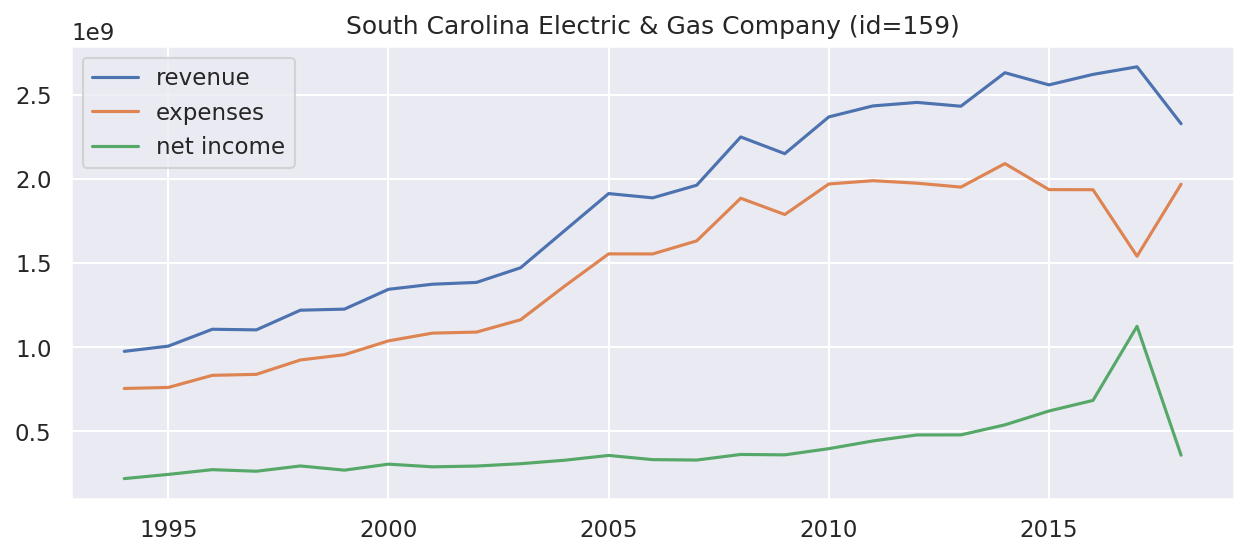

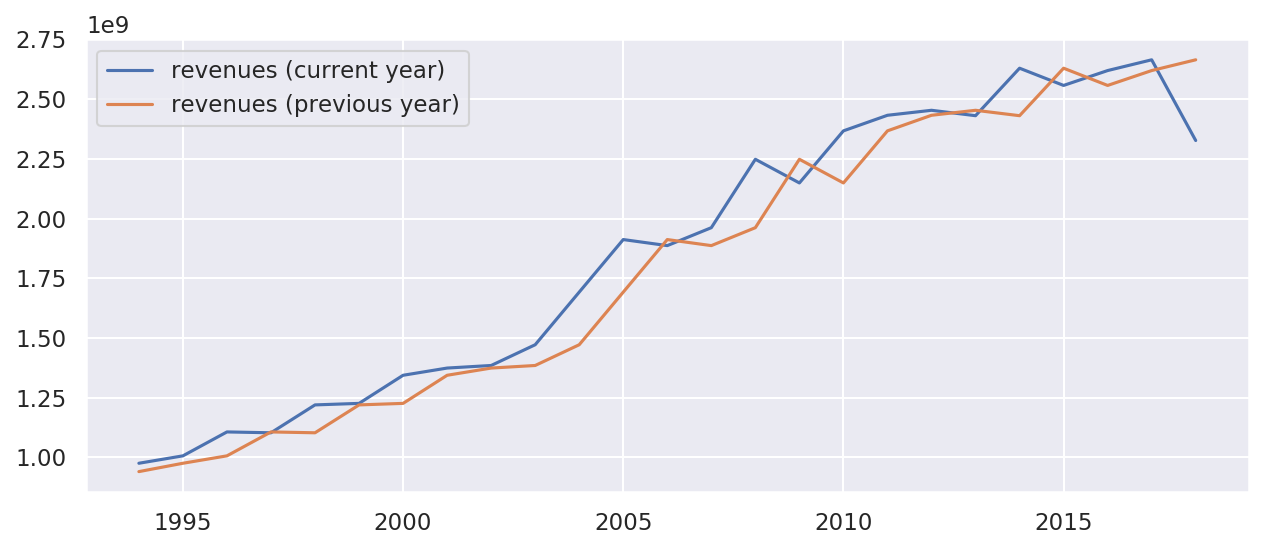

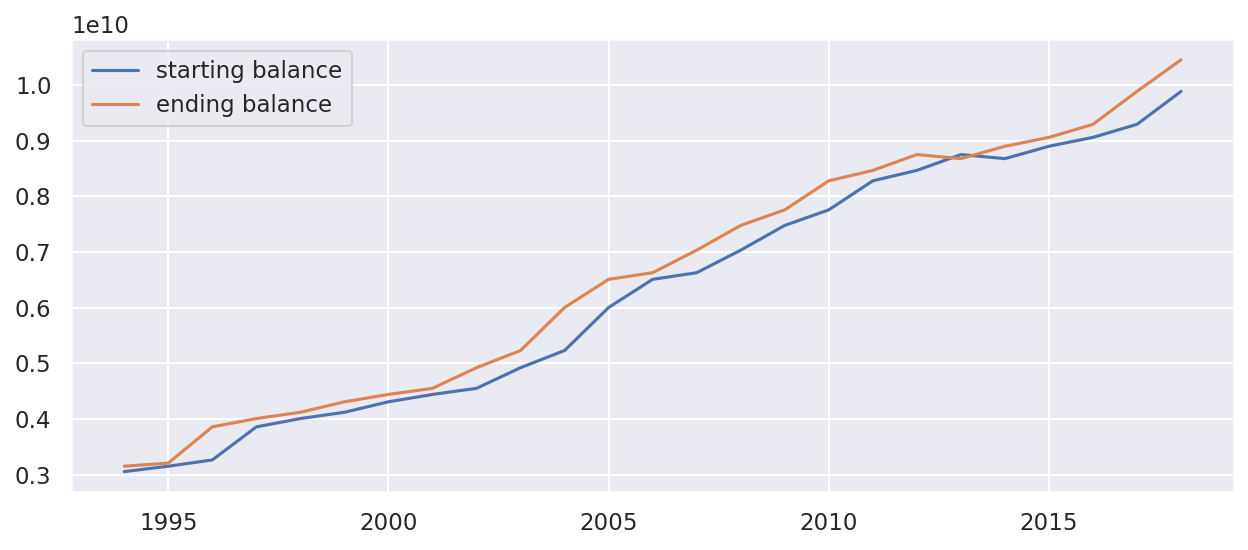

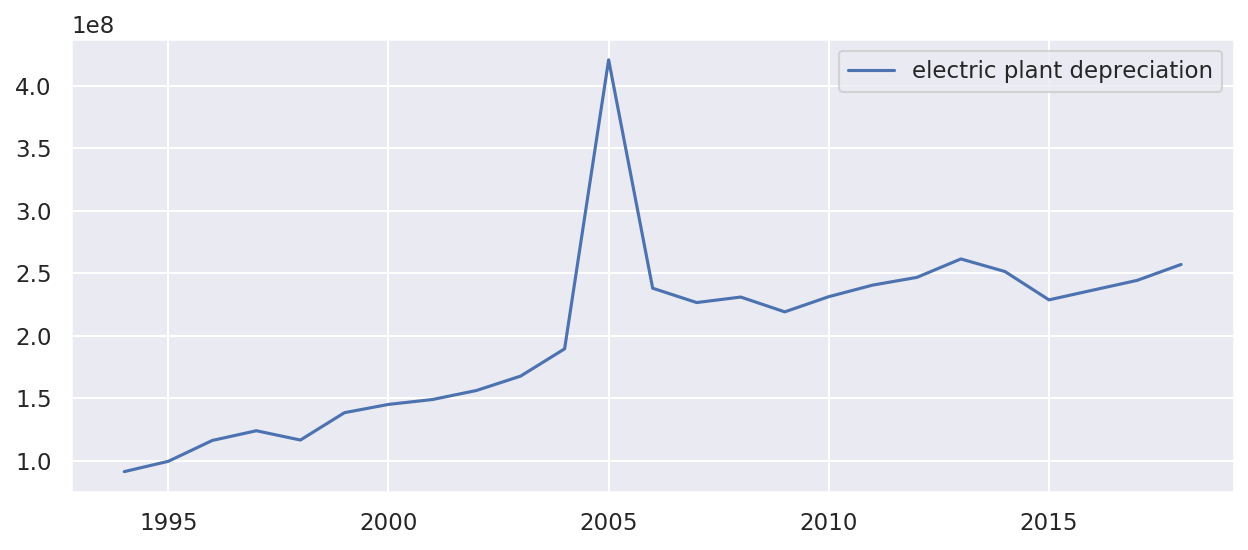

,utility_id_ferc1,utility_name_ferc1,report_year,utility_id_eia,utility_name_eia,utility_id_pudl,operating_revenues_curr_yr,operating_expenses_curr_yr,net_operating_income_curr_yr,operating_revenues_prev_yr,operating_expenses_prev_yr,net_operating_income_prev_yr,plant_starting_balance,plant_ending_balance,total_electric_plant_depreciation
3164,159,South Carolina Electric & Gas Company,1994,17539,South Carolina Electric&Gas Company,292,9.755263e+08,7.552766e+08,2.202497e+08,9.405469e+08,7.309495e+08,2.095974e+08,3.053882e+09,3.151038e+09,91183992.0
3165,159,South Carolina Electric & Gas Company,1995,17539,South Carolina Electric&Gas Company,292,1.006566e+09,7.613905e+08,2.451756e+08,9.755263e+08,7.552766e+08,2.202497e+08,3.151038e+09,3.207571e+09,99420851.0
3166,159,South Carolina Electric & Gas Company,1996,17539,South Carolina Electric&Gas Company,292,1.106664e+09,8.332471e+08,2.734172e+08,1.006566e+09,7.613905e+08,2.451756e+08,3.263933e+09,3.857613e+09,116137469.0
3167,159,South Carolina Electric & Gas Company,1997,17539,South Carolina Electric&Gas Company,292,1.103091e+09,8.390518e+08,2.640393e+08,1.106664e+09,8.332471e+08,2.734172e+08,3.857613e+09,4.007216e+09,123892463.0
3168,159,South Carolina Electric & Gas Company,1998,17539,South Carolina Electric&Gas Company,292,1.219826e+09,9.244398e+08,2.953861e+08,1.103091e+09,8.390518e+08,2.640393e+08,4.007216e+09,4.120008e+09,116448482.0
3169,159,South Carolina Electric & Gas Company,1999,17539,South Carolina Electric&Gas Company,292,1.226166e+09,9.556591e+08,2.705073e+08,1.219826e+09,9.244398e+08,2.953861e+08,4.120008e+09,4.307607e+09,138333933.0
3170,159,South Carolina Electric & Gas Company,2000,17539,South Carolina Electric&Gas Company,292,1.343830e+09,1.037763e+09,3.060670e+08,1.226166e+09,9.556591e+08,2.705073e+08,4.307607e+09,4.440045e+09,144956855.0
3171,159,South Carolina Electric & Gas Company,2001,17539,South Carolina Electric&Gas Company,292,1.374033e+09,1.083767e+09,2.902659e+08,1.343830e+09,1.037763e+09,3.060670e+08,4.440045e+09,4.549936e+09,148877664.0
3172,159,South Carolina Electric & Gas Company,2002,17539,South Carolina Electric&Gas Company,292,1.384814e+09,1.089935e+09,2.948790e+08,1.374033e+09,1.083767e+09,2.902659e+08,4.549936e+09,4.920841e+09,156115551.0
3173,159,South Carolina Electric & Gas Company,2003,17539,South Carolina Electric&Gas Company,292,1.471677e+09,1.162914e+09,3.087636e+08,1.384814e+09,1.089935e+09,2.948790e+08,4.920841e+09,5.229381e+09,167592604.0


In [200]:
util_id = random.choice(binz_out.utility_id_ferc1.unique())
util = binz_out.query("utility_id_ferc1==@util_id")

plt.plot(util.report_year, util.operating_revenues_curr_yr, label="revenue")
plt.plot(util.report_year, util.operating_expenses_curr_yr, label="expenses")
plt.plot(util.report_year, util.net_operating_income_curr_yr, label="net income")
plt.title(f"{util.utility_name_ferc1.values[0]} (id={util_id})")
plt.legend()
plt.show()

plt.plot(util.report_year, util.operating_revenues_curr_yr, label="revenues (current year)")
plt.plot(util.report_year, util.operating_revenues_prev_yr, label="revenues (previous year)")
plt.legend()
plt.show()

plt.plot(util.report_year, util.plant_starting_balance, label="starting balance")
plt.plot(util.report_year, util.plant_ending_balance, label="ending balance")
plt.legend()
plt.show()

plt.plot(util.report_year, util.total_electric_plant_depreciation, label="electric plant depreciation")
plt.legend()
plt.show();

util

## Missing Utilities:
There are 4 requested utilities that don't show up in the outputs.

-------------------------------------------------------------------------------------------------------
| utility_id_eia | utility_name_eia                   | Notes
|----------------|------------------------------------|------------------------------------------------
| 22500          | Westar Energy (KPL)                | Needs mapping: FERC (191, 276?) to EIA 22500
| 13780          | Northern States Power Company (WI) | In EIA 861, not 860. Shows up as FERC 121 
| 13809          | Nortwestern Public Service Co (SD) | Needs mapping: FERC 122 to EIA (13809, 13902)
| 19446          | Union Light Heat & Power Co (KY)   | ULF&P became Cinergy in 1994 via a merger.
|                |                                    | In EIA 861 19446 is Duke Energy KY, but in
|                |                                    | EIA 860 Duke Energy KY is 55729 (FERC 178)



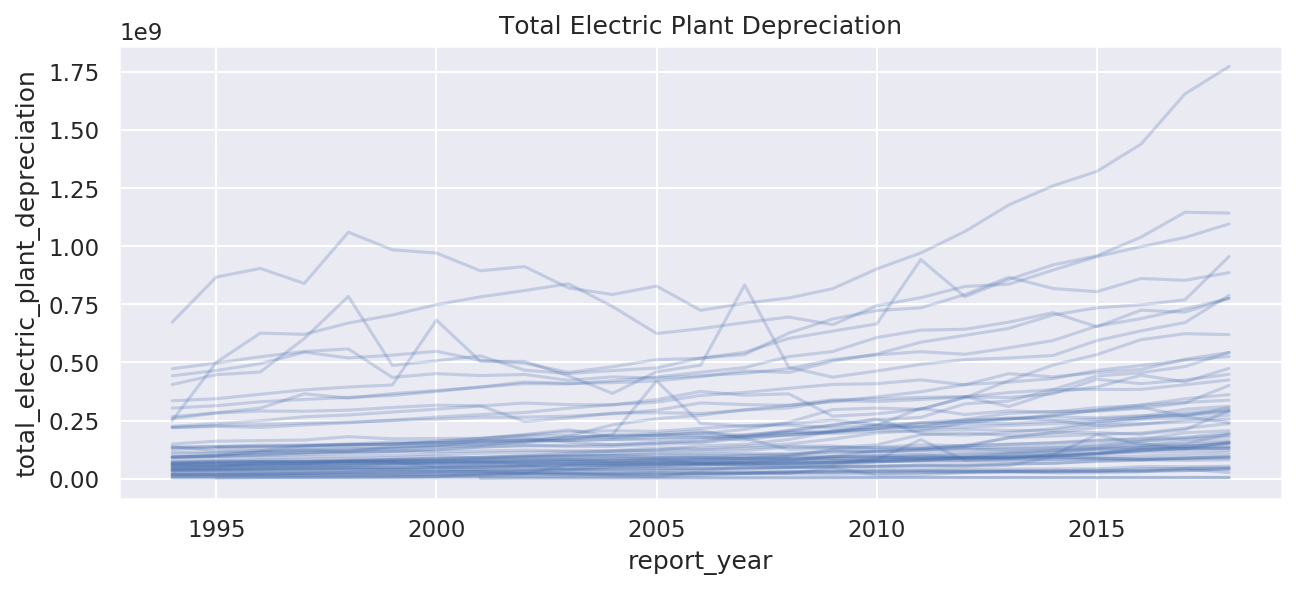

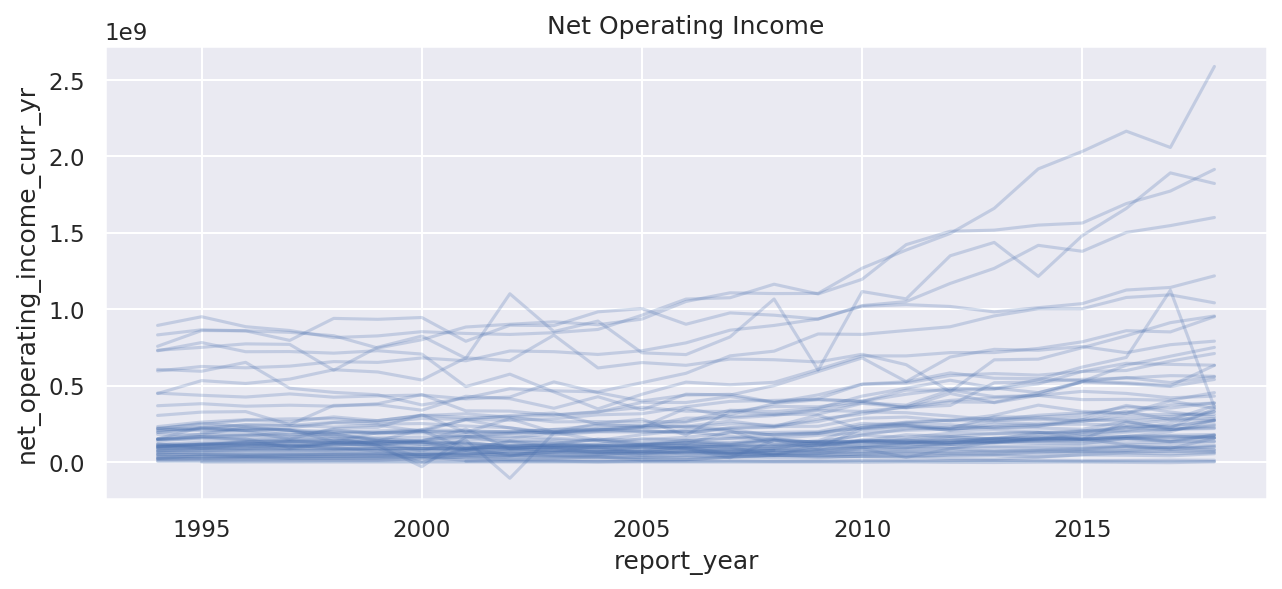

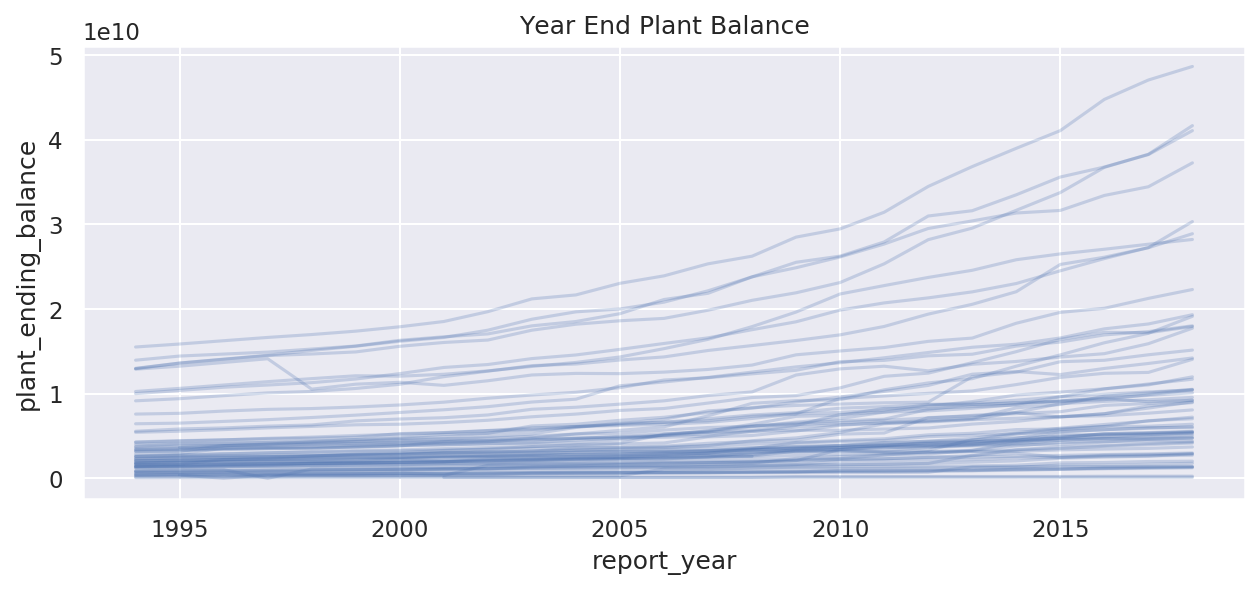

In [198]:
sns.lineplot(x=binz_out.report_year, y=binz_out.total_electric_plant_depreciation, units=binz_out.utility_id_ferc1, estimator=None, alpha=0.25)
plt.title("Total Electric Plant Depreciation")
plt.show();

sns.lineplot(x=binz_out.report_year, y=binz_out.net_operating_income_curr_yr, units=binz_out.utility_id_ferc1, estimator=None, alpha=0.25)
plt.title("Net Operating Income")
plt.show();

sns.lineplot(x=binz_out.report_year, y=binz_out.plant_ending_balance, units=binz_out.utility_id_ferc1, estimator=None, alpha=0.25)
plt.title("Year End Plant Balance")
plt.show();

In [199]:
binz_out.to_csv("rbinz_heco1.csv", index=False)

In [212]:
len(binz_out.utility_id_ferc1.unique())

59

In [221]:
out_idx = pd.Index(binz_out.utility_id_eia.sort_values().dropna().unique())

In [222]:
in_idx = pd.Index(output_utils.utility_id_eia.sort_values().unique())

In [223]:
out_idx.symmetric_difference(in_idx)

Int64Index([12199, 13902], dtype='int64')

In [224]:
output_utils.query("utility_id_eia==12199")

,utility_id_eia,utility_name_eia_rbinz,questionable,utility_name_eia_pudl,utility_id_pudl,utility_id_ferc1,utility_name_ferc1
35,12199,"MDU Resources Group, Inc.",False,Montana-Dakota Utilities Co,193,103,Montana-Dakota Utilities Company


In [228]:
income_out.query("utility_id_ferc1==103")

,utility_id_ferc1,utility_name_ferc1,report_year,utility_id_eia,utility_name_eia,utility_id_pudl,operating_revenues_curr_yr,operating_expenses_curr_yr,net_operating_income_curr_yr,operating_revenues_prev_yr,operating_expenses_prev_yr,net_operating_income_prev_yr
